In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f"Parent directory: {parent_dir}")

Parent directory: /u/weim/lob


In [2]:
lots_list = [20,60]
n_samples = 10000
# n_samples = 10
train_iter = 400
# train_iter = 4
batch_size = 12800
# batch_size = 40

folder_path = f"{parent_dir}/rewards"
data = {}
agent_list = ['log_normal', 'log_normal_order_info', 'log_normal_volume', 'log_normal_drift']
# for env in ['noise', 'flow', 'strategic']:
for env in ['noise', 'flow', 'strategic']:  
    data[env] = {}
    for lots in lots_list:
        data[env][lots] = {}
        for agent in agent_list:            
            try: 
                # 'rewards/flow_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_order_info.npz'
                # /u/weim/lob/rewards/strategic_60_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_drift.npz
                # loading from deterministic action 
                name =  f'{folder_path}/{env}_{lots}_seed_0_eval_seed_100_eval_episodes_{n_samples}_num_iterations_{train_iter}_bsize_{batch_size}_{agent}_deterministic_action.npz'
                print(f'loading data from: {name}')
                data[env][lots][agent] = np.load(name)['rewards']
            except:
                print(f"path doesnt exist: {name}")
                data[env][lots][agent] = 'no data aviailable'

loading data from: /u/weim/lob/rewards/noise_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_deterministic_action.npz
loading data from: /u/weim/lob/rewards/noise_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_order_info_deterministic_action.npz
loading data from: /u/weim/lob/rewards/noise_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_volume_deterministic_action.npz
loading data from: /u/weim/lob/rewards/noise_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_drift_deterministic_action.npz
loading data from: /u/weim/lob/rewards/noise_60_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_deterministic_action.npz
loading data from: /u/weim/lob/rewards/noise_60_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_order_info_deterministic_action.npz
loading data from: /u/weim/lo

In [3]:
lots = 60
print(np.mean(data['strategic'][lots]['log_normal'])) 
print(np.mean(data['strategic'][lots]['log_normal_order_info'])) 
print(np.mean(data['strategic'][lots]['log_normal_volume'])) 
print(np.mean(data['strategic'][lots]['log_normal_drift'])) 


0.23470723421263
0.10441769074499618
0.10251939920738008
0.0005245803357313922


In [4]:
translator = {'log_normal_order_info': 'LN-O', 'log_normal_volume': 'LN-V', 'log_normal_drift': 'LN-D', 'log_normal': 'LN'}
list_of_dfs = []
envs = ['noise', 'flow', 'strategic']
# 'for env in ['noise', 'flow', 'strategic']:    
agent_list = ['log_normal_drift', 'log_normal_volume', 'log_normal_order_info', 'log_normal']
for env in envs:    
    data_for_df = {}
    for agent in agent_list:
        print(agent)
        name = translator[agent]
        data_for_df[f'E[{name}]'] = []
        data_for_df[f'Std[{name}]'] = []
        for lots in lots_list:
            try:
                data_for_df[f'Std[{name}]'] += [np.std(data[env][lots][agent])]
                data_for_df[f'E[{name}]'] += [np.mean(data[env][lots][agent])]                
            except:
                print(f"no data available for {env}, {lots}, {agent}")
                data_for_df[f'Std[{name}]'] += [np.nan]
                data_for_df[f'E[{name}]'] += [np.nan]
    df = pd.DataFrame.from_dict(data_for_df).round(2)    
    df.index.name = 'Lots'
    index_name = [f'{env}_{l}' for l in lots_list]
    df.index = index_name
    df = df.round(2)
    list_of_dfs.append(df)

complete_df = pd.concat(list_of_dfs, axis=0)
print(complete_df)

if True: 
    highest_exp = []
    lowest_std = []
    for idx in complete_df.index:
        # expected_values = complete_df.loc[idx, ['E[SL]', 'E[TWAP]', 'E[DR]', 'E[LN]']]
        expected_values = complete_df.loc[idx, ['E[LN-O]', 'E[LN-V]', 'E[LN]', 'E[LN-D]']]
        max_idx = expected_values.idxmax()
        highest_exp.append((idx, max_idx))
        # std_values = complete_df.loc[idx, ['Std[SL]', 'Std[TWAP]', 'Std[DR]', 'Std[LN]']]
        std_values = complete_df.loc[idx, ['Std[LN-O]', 'Std[LN-V]', 'Std[LN]', 'Std[LN-D]']]
        min_idx = std_values.idxmin()
        lowest_std.append((idx, min_idx))

    complete_df = complete_df.astype(str)
    for idx, max_idx in highest_exp:
        complete_df.loc[idx, max_idx] = fr"\textbf{{{complete_df.loc[idx, max_idx]}}}"

    # only highlight expected values
    # for idx, min_idx in lowest_std:
    #     complete_df.loc[idx, min_idx] = fr"\textbf{{{complete_df.loc[idx, min_idx]}}}"

    complete_df = complete_df.drop(['noise', 'flow', 'strategic'], errors='ignore')
    complete_df.insert(0, r'\#Lots', complete_df.index.astype(str))
    # complete_df.iloc[:,0] = [20,60]*3
    complete_df.iloc[:,0] = [20,60]*3

    complete_df.insert(0, r'Market', complete_df.index.astype(str))
    complete_df.iloc[:,0] = ['Noise', '', 'Noise \& Tactical', '', 'Noise \& Tactical', '\& Strategic']
    # complete_df.iloc[:,0] = ['Noise', '', 'Noise \& Tactical', '']

    rename_dict = {'E[LN-O]': r'$\mathbb{E}[\text{LN-O}]$', 'Std[LN-O]': r'$\sigma[\text{LN-O}]$', 
                'E[LN-V]': r'$\mathbb{E}[\text{LN-V}]$', 'Std[LN-V]': r'$\sigma[\text{LN-V}]$', 
                'E[LN-D]': r'$\mathbb{E}[\text{LN-D}]$', 'Std[LN-D]': r'$\sigma[\text{LN-D}]$', 
                'E[LN]': r'$\mathbb{E}[\text{LN}]$', 'Std[LN]': r'$\sigma[\text{LN}]$',
                # 'E[LNS]': r'$\mathbb{E}[\text{LNS}]$', 'Std[LNS]': r'$\sigma[\text{LNS}]$'
                }
    print(complete_df)
    complete_df = complete_df.rename(columns=rename_dict)
    complete_df = complete_df.where(pd.notnull(complete_df), '')

    latex_table = complete_df.to_latex(float_format="%.2f", index=False, column_format='l'+'c'*9, escape=False)
    # saving_path = f"{folder_path}/results_table_latest_with_dirichlet_{tag}.tex" if tag is not None else f"{folder_path}/results_table_latest_with_dirichlet.tex"    
    saving_path = f"{parent_dir}/latex_tables/results_table_feature_importance_deterministic_action.tex" 
    # tag = '' if tag is None else tag
    tag = 'feature_importance'
    with open(saving_path, "w") as f:
        content = (
            r"\begin{table}[htpb]"+
            r"\label{table:" + tag +"}"+
            r"\begin{center}"+
            r"    \begin{scriptsize}"+
            r"        \begin{sc}"
            + latex_table +
            r"        \end{sc}"+
            r"    \end{scriptsize}"+
            r"\end{center}"+
            r"\end{table}"        
        )
        f.write(content)

log_normal_drift
log_normal_volume
log_normal_order_info
log_normal
log_normal_drift
log_normal_volume
log_normal_order_info
log_normal
log_normal_drift
log_normal_volume
log_normal_order_info
log_normal
              E[LN-D]  Std[LN-D]  E[LN-V]  Std[LN-V]  E[LN-O]  Std[LN-O]  \
noise_20         0.61       1.04     0.38       0.94     0.61       1.01   
noise_60        -0.79       0.86    -0.73       0.95    -0.77       1.03   
flow_20          0.76       0.64     0.58       0.62     0.78       0.64   
flow_60         -0.25       0.67    -0.36       0.64    -0.23       0.68   
strategic_20     0.99       2.20     0.69       2.73     1.09       2.28   
strategic_60     0.00       2.22     0.10       2.17     0.10       1.96   

              E[LN]  Std[LN]  
noise_20       0.61     1.03  
noise_60      -0.72     0.90  
flow_20        0.81     0.64  
flow_60       -0.25     0.67  
strategic_20   1.13     2.08  
strategic_60   0.23     2.15  
                         Market \#Lots E[LN-D]

plotting for: noise-20-log_normal_drift
plotting for: noise-20-log_normal_volume
plotting for: noise-20-log_normal_order_info
plotting for: noise-20-log_normal
plotting for: noise-60-log_normal_drift
plotting for: noise-60-log_normal_volume
plotting for: noise-60-log_normal_order_info
plotting for: noise-60-log_normal
plotting for: flow-20-log_normal_drift
plotting for: flow-20-log_normal_volume
plotting for: flow-20-log_normal_order_info
plotting for: flow-20-log_normal
plotting for: flow-60-log_normal_drift
plotting for: flow-60-log_normal_volume
plotting for: flow-60-log_normal_order_info
plotting for: flow-60-log_normal
plotting for: strategic-20-log_normal_drift
plotting for: strategic-20-log_normal_volume
plotting for: strategic-20-log_normal_order_info
plotting for: strategic-20-log_normal
plotting for: strategic-60-log_normal_drift
plotting for: strategic-60-log_normal_volume
plotting for: strategic-60-log_normal_order_info
plotting for: strategic-60-log_normal


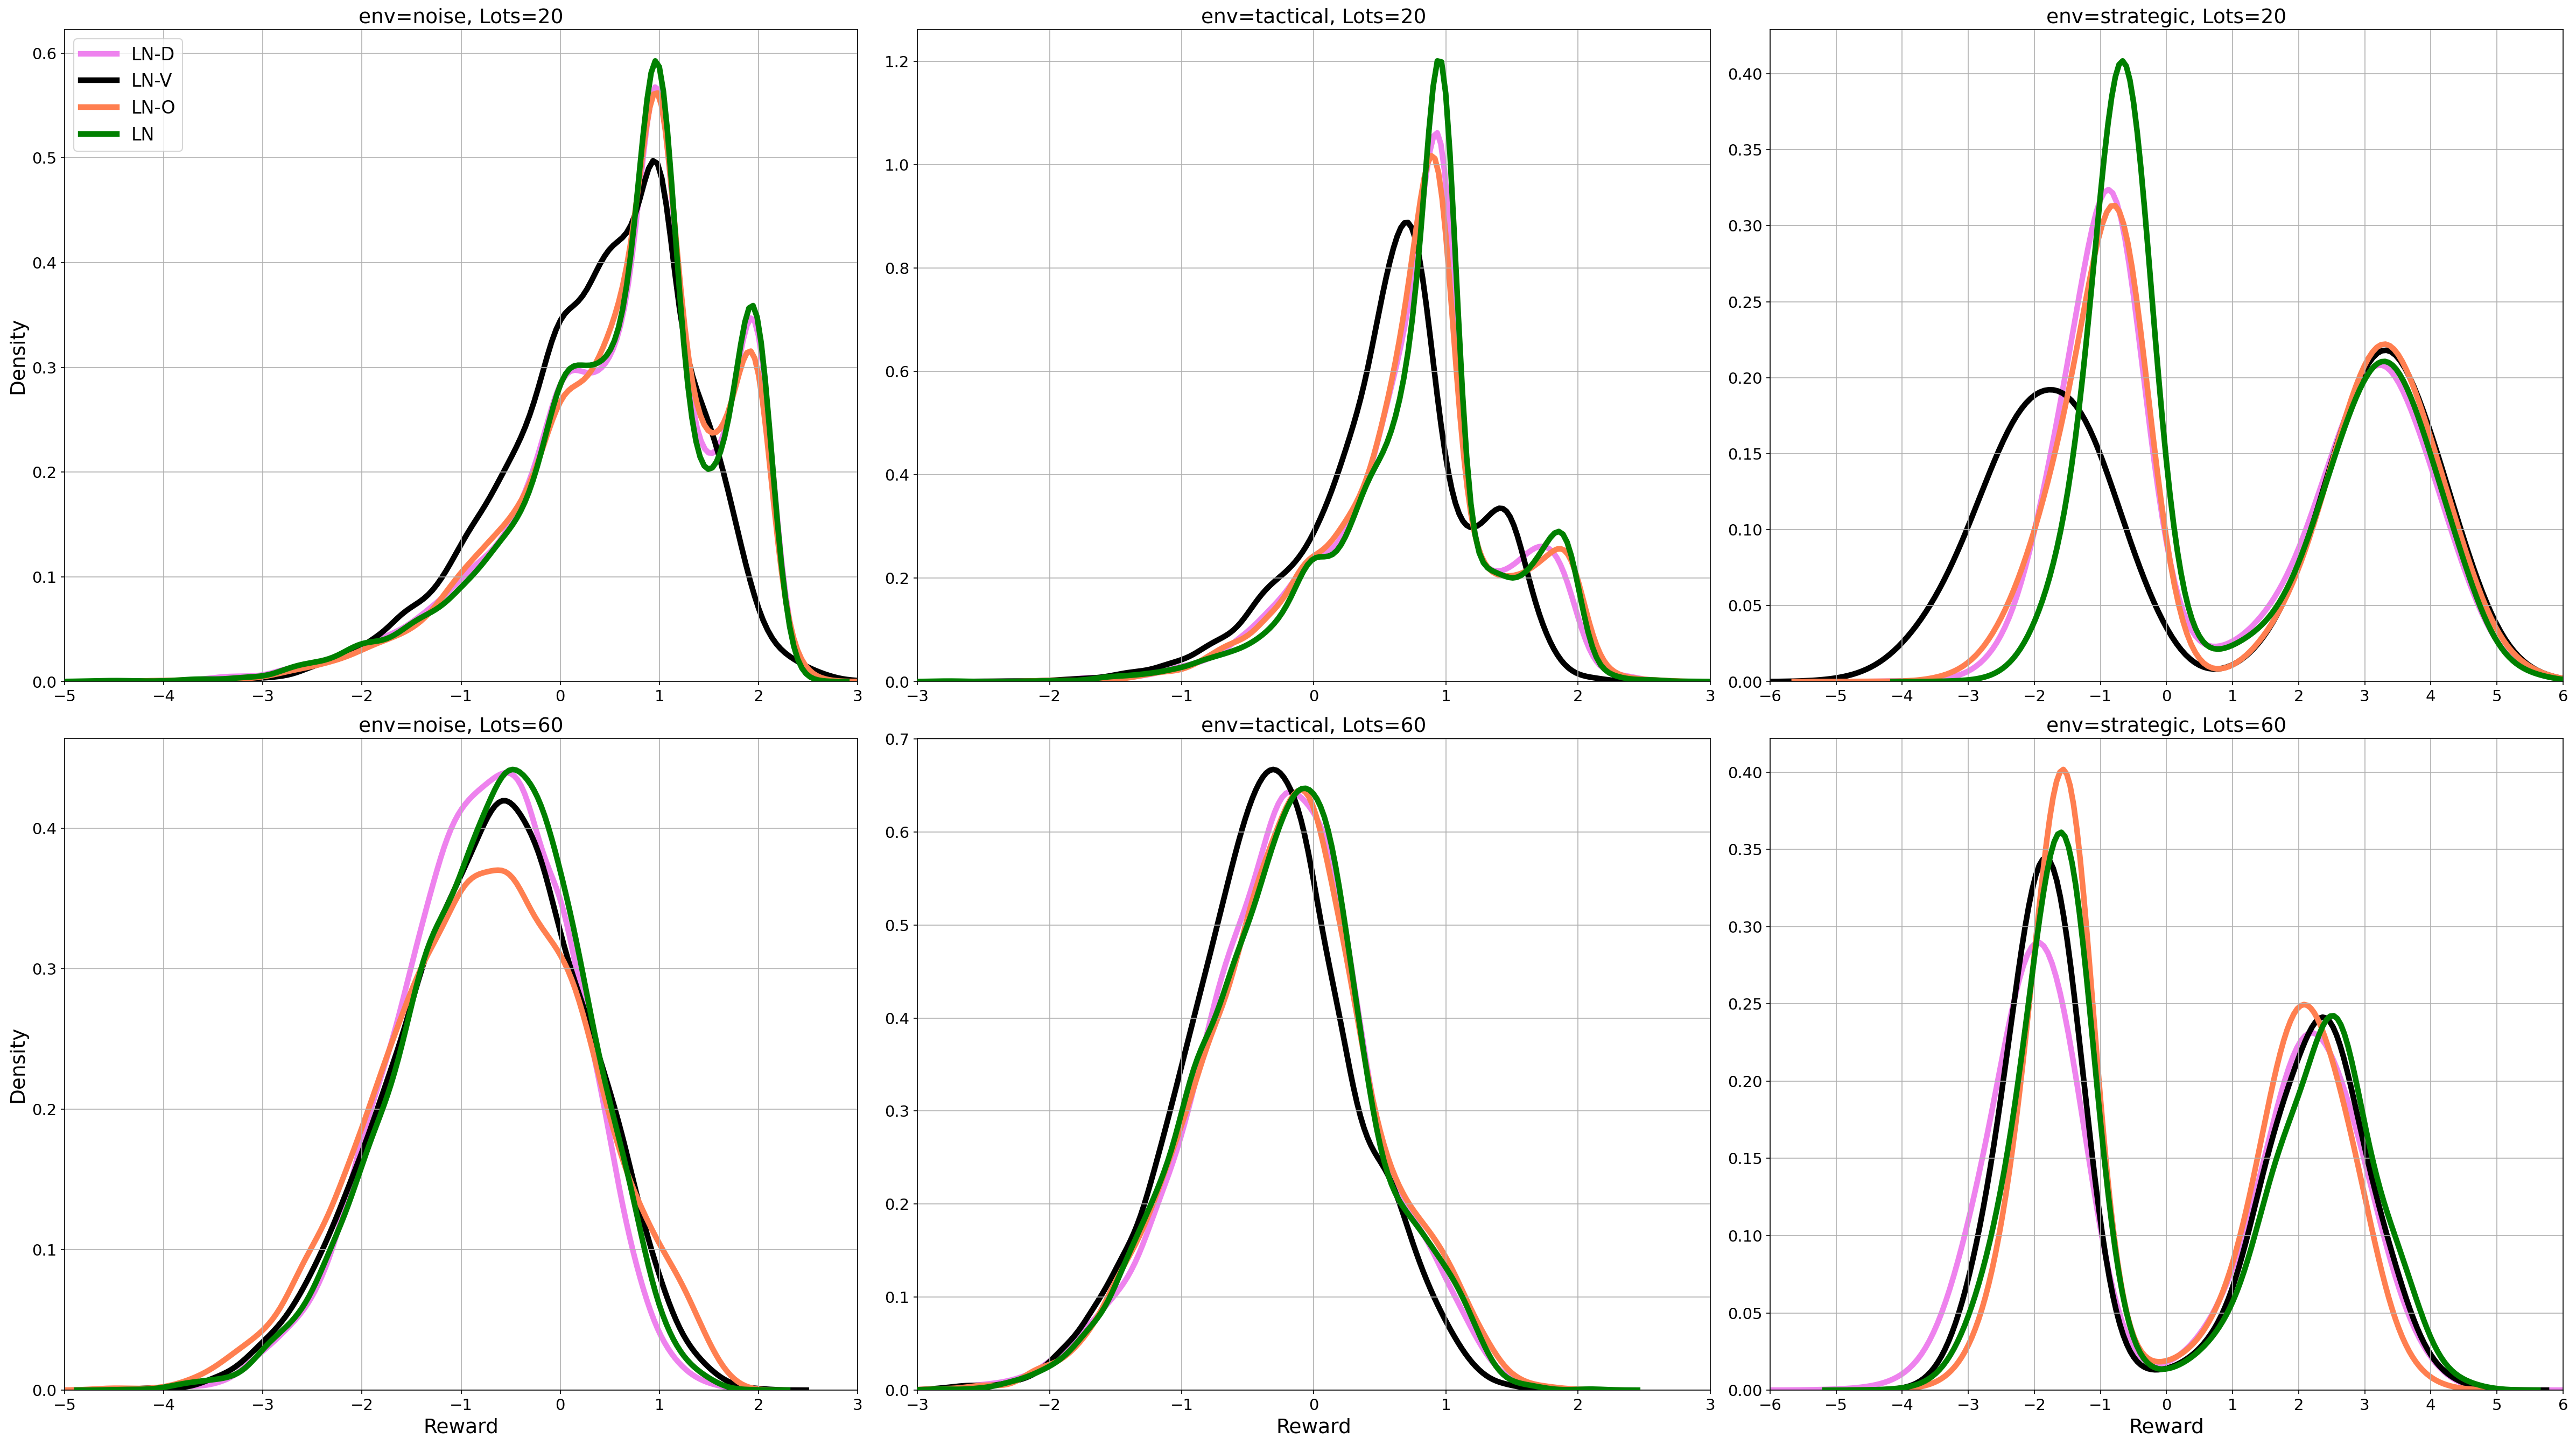

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(2*16, 2*9), dpi=300)
translator = {'log_normal_order_info': 'LN-O', 'log_normal_volume': 'LN-V', 'log_normal_drift': 'LN-D', 'log_normal': 'LN'}
envs = ['noise', 'flow', 'strategic']
# ensure these are used for plotting (in the same order as agent_list)
colors = ['violet', 'black', 'coral', 'green']
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
color_map = dict(zip(agent_list, colors))
for i, env in enumerate(envs):
    for j, lots in enumerate(lots_list):
        ax = axs[j, i]
        for agent in agent_list:
            print(f'plotting for: {env}-{lots}-{agent}')
            try:
                # sns.kdeplot(data[env][lots][agent], fill=False, label=translator[agent], bw_adjust=1, linewidth=5, ax=ax, color=color_map[agent])
                sns.kdeplot(
                    data[env][lots][agent],
                    fill=False,
                    label=translator[agent],
                    bw_adjust=1,
                    linewidth=5,
                    ax=ax,
                    color=color_map[agent],
                    zorder=10 if agent == 'log_normal' else 1
                )

            except: 
                print(f"no data available for {env}, {lots}, {agent}")
        if env == 'noise' and lots == 20:
            ax.legend(prop={'size': 16}, loc='upper left')
        fig.set_dpi(150)
        if j == 1:
            ax.set_xlabel('Reward', fontsize=18)
        if i == 0:
            ax.set_ylabel('Density', fontsize=18)
        else:
            ax.set_ylabel('')
        if i == 0:
            ax.set_title(f'Noise', fontsize=18)
        if env == 'flow':
            ax.set_title(f'env=tactical, Lots={lots}', fontsize=18)
        else:
            ax.set_title(f'env={env}, Lots={lots}', fontsize=18)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.grid()
        ax.set_xticks(np.arange(-10, 10, 1))
        if env == 'flow':
            ax.set_xlim(-3, 3)
        elif env == 'strategic':
            ax.set_xlim(-6, 6)
        else:
            ax.set_xlim(-5, 3)
plt.tight_layout()
plt.savefig(f'{parent_dir}/plots/reward_distribution_combin.pdf')

#############
generating plots for  noise
#############
generating plots for  flow
#############
generating plots for  strategic


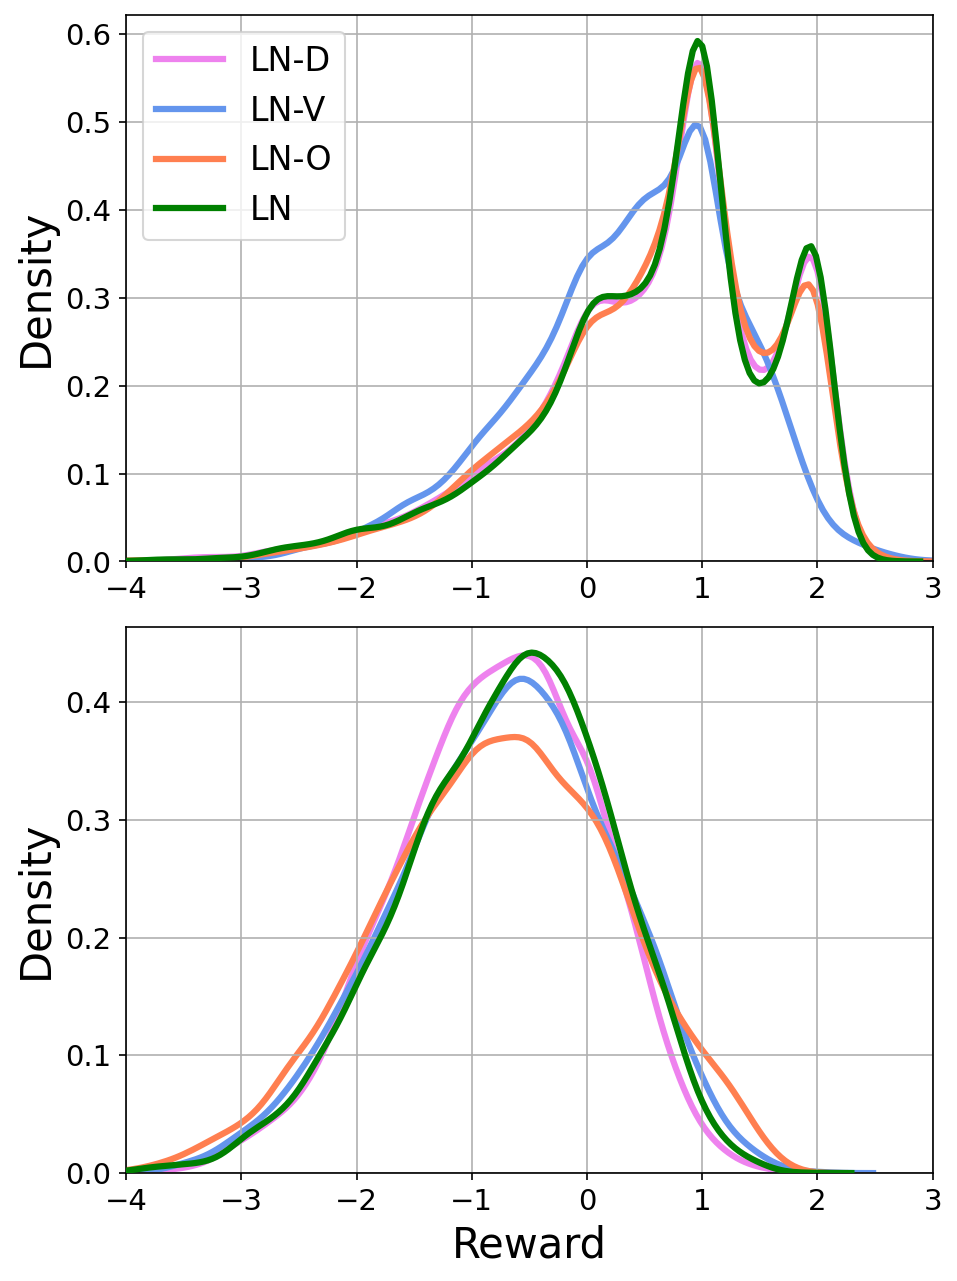

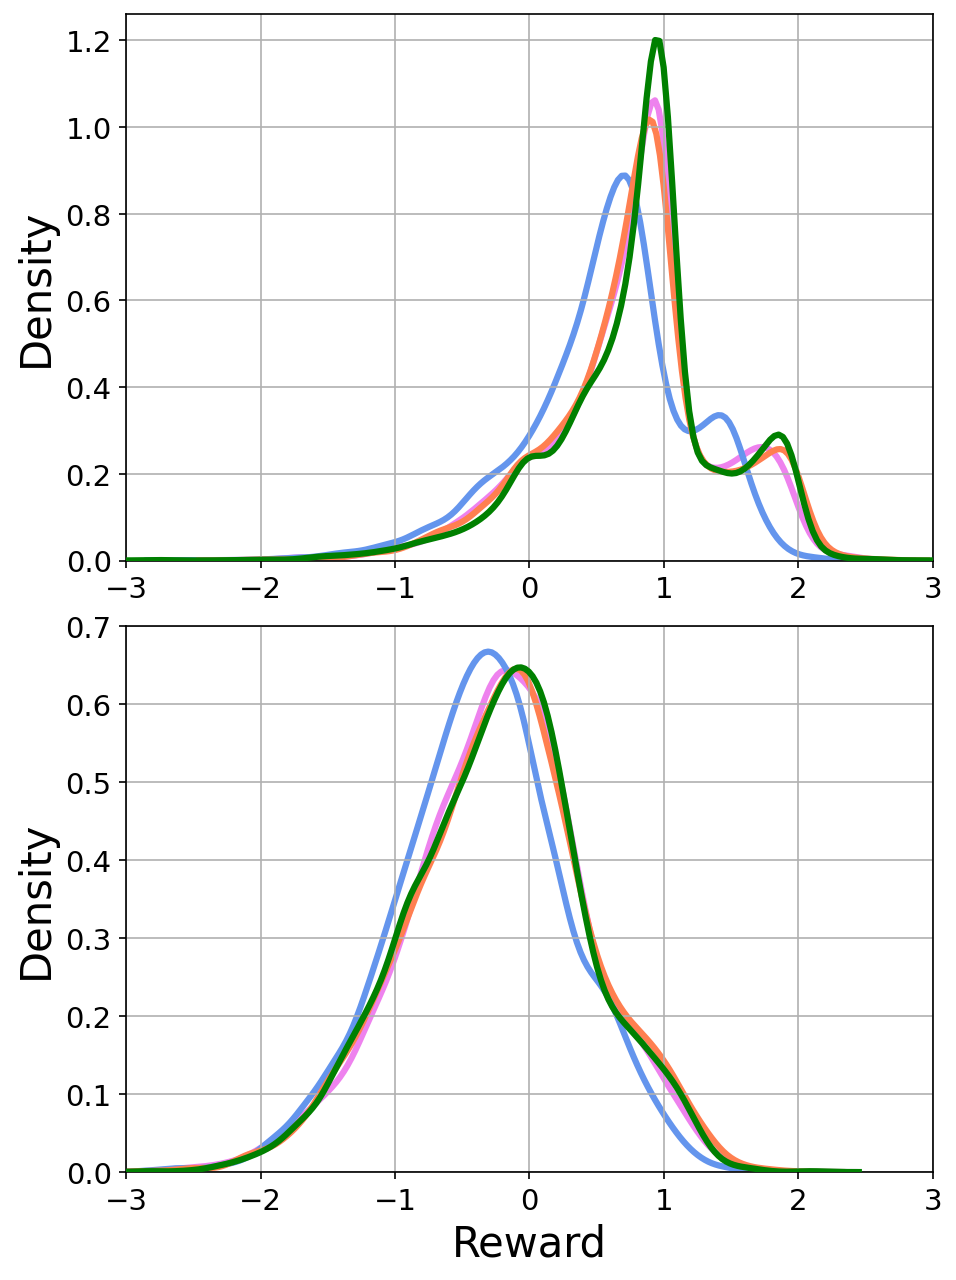

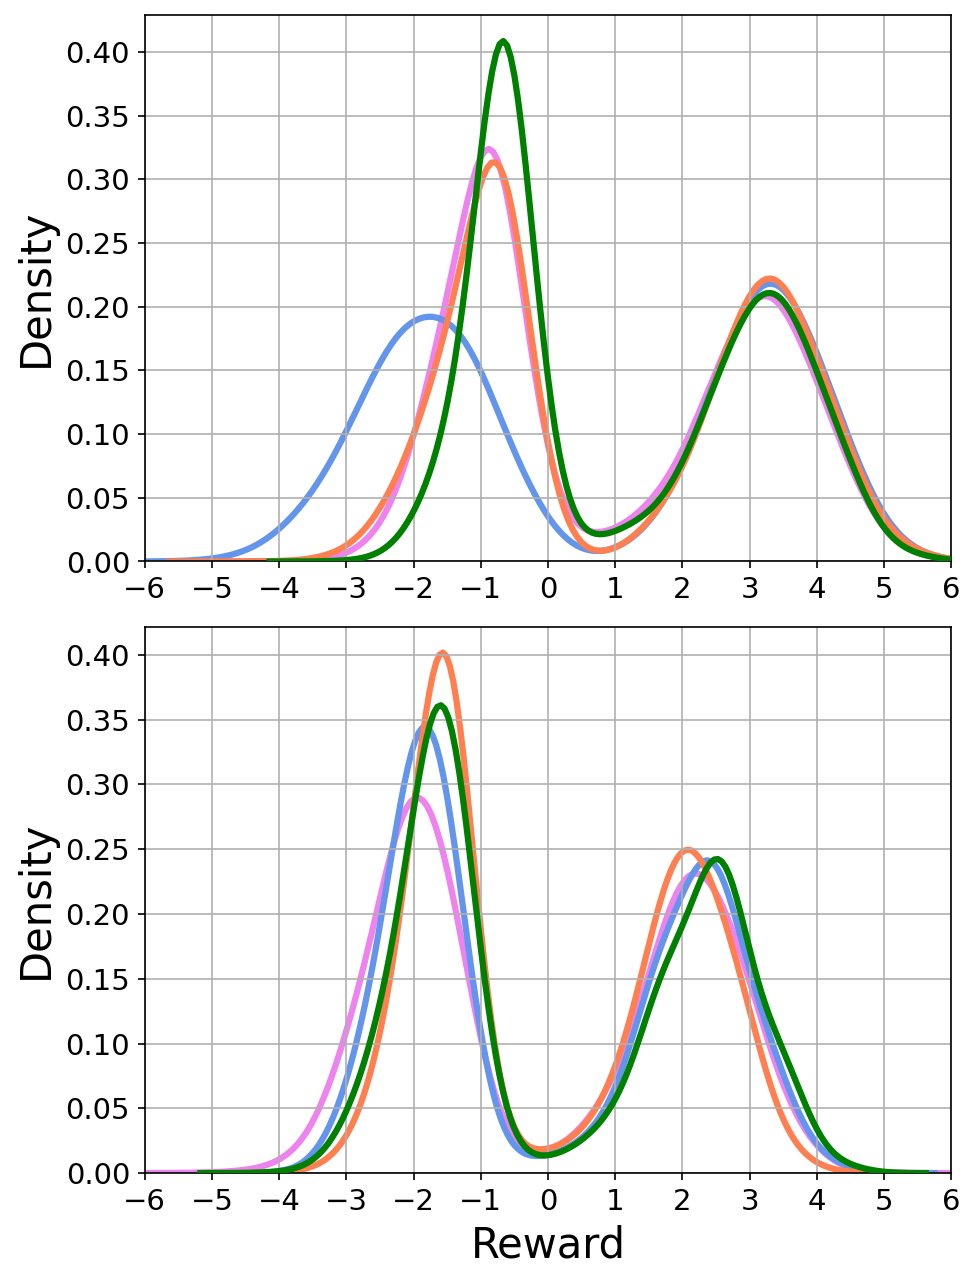

In [ ]:

lots_list = [20, 60]
textwidth = 6.75
textheight = 9
scale = 3.2

colors = ['violet', 'cornflowerblue', 'coral', 'green']
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
color_map = dict(zip(agent_list, colors))

envs = ['noise', 'flow', 'strategic']
for i, env in enumerate(envs):
    print('#############')
    print('generating plots for ', env)
    fig, axs = plt.subplots(2, 1, figsize=(scale*0.3*textwidth, scale*0.3*textheight), dpi=300)
    for j, lots in enumerate(lots_list):
        ax = axs[j]
        for agent in agent_list:
            # names = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'actor_critic': 'RL'} 
            # name_translation = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'log_normal': 'LN', 'dirichlet': 'DR'}
            name = translator[agent]
            try: 
                # sns.kdeplot(data[env][lots][agent], fill=False, label=translator[agent], bw_adjust=1, linewidth=3, ax=ax)
                if agent == 'log_normal':
                    z_order = 10
                else:
                    z_order = 1
                sns.kdeplot(
                    data[env][lots][agent],
                    fill=False,
                    label=translator[agent],
                    bw_adjust=1,
                    linewidth=3,
                    ax=ax,
                    color=color_map[agent],
                    zorder=z_order
                )
            except: 
                print(f"no data available for {env}, {lots}, {agent}")
        if env == 'noise' and lots == 20:   
            ax.legend(prop={'size': 16}, loc='upper left')
        # set legend at the top of ech market. can comment this out if necessary. 
        # if j == 0:
            # ax.legend(prop={'size': 16}, loc='upper left')  
        fig.set_dpi(150)
        if j == 1:
            ax.set_xlabel('Reward', fontsize=20)
            # ax.set_xlabel('X', fontsize=20)
        # ax.set_title(f'{env}', fontsize=18)
        if i == 0:
            ax.set_ylabel('Density', fontsize=20)
        else:
            ax.set_ylabel('')
        # set density label everywhere
        # comment out if necessary 
        ax.set_ylabel('Density', fontsize=20)
        # if i == 0:
            # ax.set_title(f'Noise', fontsize=18)
        # if j == 0:
        # ax.set_title(f'#Lots={n_lots}', fontsize=18)
        tick_size = 14
        ax.tick_params(axis='x', labelsize=tick_size)
        ax.tick_params(axis='y', labelsize=tick_size)
        ax.grid()
        ax.set_xticks(np.arange(-10, 10, 1))
        if env == 'flow':
            ax.set_xlim(-3, 3)
        elif env == 'strategic':
            ax.set_xlim(-6, 6)
        else:
            ax.set_xlim(-4, 3)
    plt.tight_layout()
    plt.savefig(f'{parent_dir}/plots/reward_distribution_{env}_feature_importance_deterministic_actions.pdf')